In [1]:
import sys
sys.path.append('../stamp_detection/faster_RCNN/')
sys.path.append('../stamp_detection/')
from stamp_dataset_class import StampDataset

import os
import torch
import pandas as pd
from IPython.display import clear_output
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn

from engine import evaluate
import utils
import transforms as T

import numpy as np
import matplotlib.pyplot as plt
import cv2

from torchvision import transforms
import numpy as np
from tqdm.notebook import tqdm
import albumentations as A
import pickle as pkl

In [2]:
@torch.no_grad()
def detection_inference(model, data_loader, device):
    
    model.eval()
    model.to(device)
    preprocess = get_transform(train=False)
    
    preds = []
    with torch.no_grad():
        for i, (X_i, Y_i) in enumerate(tqdm(test_dataset)):
            X_i_GPU = X_i.to(device)[None, :]
            preds += [{k: v.cpu().detach().numpy() for k,v in res.items()} for res in model(X_i_GPU)]
            del X_i_GPU

    return preds

In [14]:
!aws s3 cp stamp_classification/SiameseStampNet-checkpoint.pt s3://beautifeye-pub/Doc2Answer/models/stamp-classifier.pt

upload: stamp_classification/SiameseStampNet-checkpoint.pt to s3://beautifeye-pub/Doc2Answer/models/stamp-classifier.pt


In [3]:
# load detection

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint_path = '../best_models_to_date/stamp_detection/FasterRCNN-checkpoint.pt'#'trained_models_v4/checkpoint_v4-07.pt'
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=True)
model.to(device)
model.eval()
print('Model loaded successfully!')

Model loaded successfully!


In [ ]:
# load classification

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50 


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()

        self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
        self.feature_extractor.classifier[1] = nn.Conv2d(512, 2048, kernel_size=(1,1), stride=(1,1))
        self.linear = nn.Sequential(nn.Linear(2048, 2048), nn.Sigmoid())

    def forward_one(self, x):
        x = self.feature_extractor(x)
        x = (self.linear(x) * 2.) - 1
        x = x / (torch.norm(x, dim=1, keepdim=True) + 1e-6)
        return x

    def forward(self, x_pair):
        x1, x2 = x_pair[:,:3], x_pair[:,3:]
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        sim = (torch.sum(torch.mul(out1, out2), dim=1) + 1) / 2.
        return sim


In [5]:
siamese_model = Siamese()
checkpoint = torch.load('stamp_classification/SiameseStampNet-checkpoint.pt', map_location=device)
siamese_model.load_state_dict(checkpoint)
siamese_model.to(device)
siamese_model.eval()
print('Model successfully loaded')

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


Model successfully loaded


/home/ubuntu/storage/Doc2Answer/download_from_drive/data/ProcessedCards/ProcessedInnerCards/11826_2b.jpg


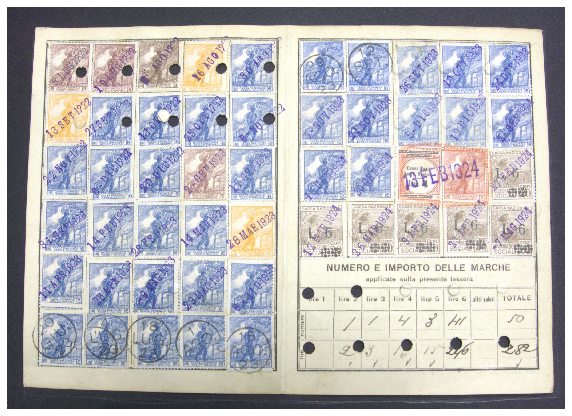

In [26]:
stamp_det_df = pd.read_pickle("../stamp_detection/test_v4_df.pkl")
img_path = sorted(stamp_det_df.path.unique())[23]
print(img_path)
plt.figure(figsize=(10,10)); plt.imshow(plt.imread(img_path)); plt.axis("off"); plt.show()

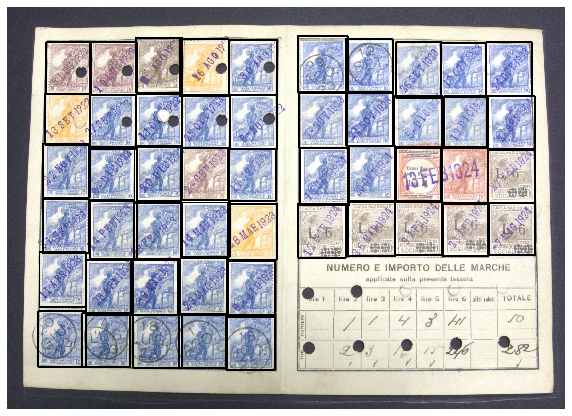

In [7]:
single_card_df = stamp_det_df.query("path == @img_path")
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

for _, row in single_card_df.iterrows():
    x1, y1, x2, y2 = row.points
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,0), 8)
    
plt.figure(figsize=(10,10)); plt.imshow(img); plt.axis("off"); plt.show()   

In [8]:
data = pd.DataFrame({'path':[img_path], 'points':[[]]})

dummy_transforms = T.Compose([T.ToTensor()])

In [23]:
import transforms as T
from torchvision.transforms import ToTensor


In [24]:
df = StampDataset(data, transforms=dummy_transforms)

In [25]:
df

In [11]:
X_gpu = df[0][0].to(device)[None]
with torch.no_grad():
    preds = [{k: v.cpu().detach().numpy() for k,v in res.items()} for res in model(X_gpu)]
del X_gpu

In [13]:
boxes = np.array([preds[0]['boxes'][i] for i in range(len(preds[0]['boxes'])) if preds[0]['scores'][i]>0.5])
boxes = np.round(boxes).astype(int)

In [14]:
dummy_transforms = A.Compose([
    A.Resize(128, 128)])

In [15]:
def preprocesses(img, boxes, show=False):
    patches = None
    img_patches = []
    for box in boxes:
        patch = img[box[1]:box[3], box[0]:box[2]].copy().astype(np.float32) / 255.
        patch = dummy_transforms(image=patch)['image']
        if show:
            img_patches.append(patch.copy())
        patch = ToTensor()(patch)[None, :]
        if patches is None:
            patches = patch
        else:
            patches = torch.cat([patches, patch], dim=0)
    if show:
        return patches, img_patches
    return patches

In [16]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
patches = preprocesses(img, boxes)

with torch.no_grad():
    patches = patches.to(device)
    vecs = siamese_model.forward_one(patches).detach().cpu().numpy()
    del patches

In [17]:
template_vecs = pkl.load(open('./stamp_classification/template_vecs.pkl','rb+'))

In [18]:
classes = []
for i in range(len(vecs)):
    scores_i = np.sum(vecs[i]* template_vecs, axis=1).ravel()
    class_i = np.argmax(scores_i)
    classes.append(class_i)

In [19]:
import matplotlib as mpl

In [20]:
colors = list(mpl.colors.BASE_COLORS.keys())
class2color = {np.unique(classes)[i]: colors[i] for i in range(len(np.unique(classes)))}

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_vecs = PCA(2).fit_transform(vecs) + (np.random.random(size=(len(vecs),2))-.5) * 1e-1

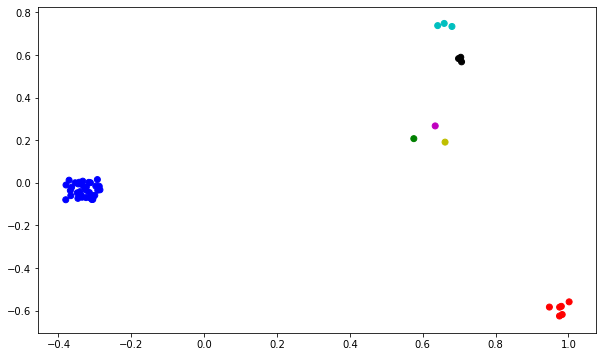

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(pca_vecs[:,0], pca_vecs[:,1], color=[class2color[classes[i]] for i in range(len(vecs))])

In [ ]:
out_dir = './classified_stamps/out'
os.makedirs(out_dir, exist_ok=True)
images = [img]
for k, pred in enumerate(preds):
    im = images[k].copy()
    for i, ((x1, y1, x2, y2), score) in enumerate(zip(boxes, pred['scores'])):
        if score >.3:
            color = tuple([int(c) for c in (np.array(mpl.colors.BASE_COLORS[class2color[classes[i]]]) * 255).astype(np.int)])
            cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), color, 10)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(out_dir, img_path.split('/')[-1][:-4] + '_classified' + '.jpg'), im)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

In [ ]:
group_folders = [os.path.join('../stamp_detection/stamp_groups/', group) for group in sorted(os.listdir('../stamp_detection/stamp_groups/'))]

In [ ]:

fig, axes = plt.subplots(len(np.unique(classes)), 1, figsize=(8,15))
axes = axes.ravel()
for template_id, ax in zip(np.unique(classes), axes):
    group_folder = group_folders[template_id]
    fn = sorted(os.listdir(group_folder))[-1]
    temp_img = plt.imread(os.path.join(group_folder, fn))
    color = tuple([int(c) for c in (np.array(mpl.colors.BASE_COLORS[class2color[template_id]]) * 255).astype(np.int)])
    top, bottom, left, right = [15]*4
    temp_img = cv2.copyMakeBorder(temp_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    ax.imshow(temp_img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('off')
plt.show()

In [10]:
import numpy as np
x=tuple(np.random.randint(0,10, 2).astype(int))

In [11]:
type(x[0])

numpy.int64

In [12]:
x = 2
type(x)

int